In [1]:
###### To add the model aspect ######
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from chime_frb_api import frb_master
import datetime as dt

In [2]:
def scrunch_npy(npy_fil, f_scrunch=1, t_scrunch=1):
    '''
    Scrunch data in frequency and time.
    '''
    data = npy_fil
    data = data.reshape([data.shape[0] // f_scrunch, f_scrunch, data.shape[1]]).mean(axis=1)
    data = data.reshape([data.shape[0], data.shape[1] // t_scrunch, t_scrunch]).mean(axis=-1)
    return data

def calc_xticks(wfall, t_res):
    
    ts = np.sum(wfall, axis=0)
    max_ts = np.argmax(ts)
    print(max_ts)
    
    xticks = []
    num = 6 # number of xticks
    step = int(len(ts)/num)
    
    for j in range(0,num):
        x_left = max_ts - step*j
        x_right = max_ts + step*(j+1)
        
        if x_left > 0:
            xticks.append(x_left)
        if x_right < len(ts):
            xticks.append(x_right)
    
      
    xticks = np.sort(np.unique(np.array(xticks)))    
    xticks_lab = np.around((xticks - max_ts) * t_res, decimals=0).astype(int)
    
    return xticks, xticks_lab

def get_event_data(event_id, r='two'):
    
    print(event_id)
    frb_master_base_url = "http://frb-vsop.chime:8001"
    master = frb_master.FRBMaster(base_url = frb_master_base_url)
    event = master.events.get_event(event_number=int(event_id))
    beam_num = event['beam_numbers'][0]
    if beam_num < 1000:
        beam_num = '0'+str(beam_num)
    print(beam_num)

    burst_time_str = event['measured_parameters'][0]['datetime'][0:19]
    burst_time = dt.datetime.strptime(burst_time_str, "%Y-%m-%d %H:%M:%S")

    year = burst_time.strftime("%Y")
    month = burst_time.strftime("%m")
    day = burst_time.strftime("%d")

    pathfile = '/data/chime/intensity/processed/{}/{}/{}/astro_{}/{}/intensity-fitburst/'.format(year, month, day, event_id,beam_num)
    pubfile = '{}_{}_round_{}_pubplot_locked.npz'.format(event_id,beam_num,r)
    pub_npz = np.load(pathfile+pubfile, allow_pickle=True)

    wfall = pub_npz['wfall']
    model_wfall = pub_npz['model_wfall']
    model_ts = pub_npz['model_ts']
    model_spec = pub_npz['model_spec']
    spec = pub_npz['spec']
    
    return wfall, model_wfall, model_ts, model_spec, spec
    
    
    

def plot_event(wfall, model_ts, freq_res, time_res, dm, i, low_freq, high_freq, save_fname):
    
#     x_ticks, xticklabels = calc_xticks(wfall, t_res)
#     wfall = wfall[:,x_ticks[0]:x_ticks[-1]]
#     print(wfall.shape)
    
    outer_grid = gridspec.GridSpec(1, 1, wspace=0, hspace=0.25)
    for j, outer in enumerate(outer_grid):
        outer = outer
    plt.figure(figsize=(6,6))
    gs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer,
                                          width_ratios=[3, 1],
                                          height_ratios=[1, 3],
                                          hspace=0.0, wspace=0.0)

    data_im = plt.subplot(gs[2])
    data_ts = plt.subplot(gs[0], sharex=data_im)
    data_spec = plt.subplot(gs[3], sharey=data_im)
    
    vmin = np.nanpercentile(wfall, 1)
    vmax = np.nanpercentile(wfall, 99)
    


    wfall[np.isnan(wfall)] = np.nanmedian(wfall)
    
    ts = np.sum(wfall, axis=0)
    spec = np.sum(wfall, axis=1)
    print(np.min(spec), np.max(spec))
    
#     model_ts = np.sum(model_wfall, axis=0)
    model_ts = model_ts/100
    plot_time = np.arange(0,len(ts),1)
    plot_freq = np.linspace(400, 800, len(spec))

    
    #plot wfall
    data_im.imshow(wfall, aspect="auto",interpolation="nearest", 
                   vmin=vmin, vmax=vmax, cmap='viridis')

    #plot time series
    data_ts.plot(plot_time, ts, color="k", drawstyle="steps-post")
    data_ts.plot(np.arange(0,len(model_ts),1), model_ts,color="r")

    # plot spectrum
    data_spec.plot(spec, np.arange(0, len(spec)), color="k", drawstyle="steps-post")
    
    plt.setp(data_ts.get_xticklabels(), visible=False)
    data_ts.set_yticklabels([], visible=True)
    data_ts.set_yticks([])
    plt.setp(data_spec.get_yticklabels(), visible=False)
    data_spec.set_xticklabels([], visible=True)
    data_spec.set_xticks([])
    
    ## Tick Labels ###
    y_ticks = np.linspace(0,len(spec),5).astype(int)
    if y_ticks[-1] > (len(spec)-1):
        y_ticks[-1] = len(spec) - 1
    yticklabels = [800, 700, 600, 500, 400]#plot_freq[y_ticks].astype(int)
    x_ticks, xticklabels = calc_xticks(wfall, t_res)
    
    low_idx = (np.abs(plot_freq - low_freq)).argmin() ### Calculating the idx where frequency is closest ###
    high_idx = (np.abs(plot_freq - high_freq)).argmin() 
    
    data_im.axhline((wfall.shape[0]-1)-low_idx, c='white', linestyle = '--')
    data_im.axhline((wfall.shape[0]-1)-high_idx, c='white', linestyle = '--')

    
    data_im.set_yticks(y_ticks)
    data_im.set_yticklabels(yticklabels)
    data_im.set_xticks(x_ticks)
    data_im.set_xticklabels(xticklabels)
    data_im.set_ylabel("Frequency (MHz)", fontsize=8)
    data_im.set_xlabel("Time (ms)", fontsize=8)
    
    xlim = data_ts.get_xlim()
    ylim = data_ts.get_ylim()
    ypos = (ylim[1] - ylim[0]) * 0.9 + ylim[0]
    xpos = (xlim[1] - xlim[0]) * 0.98 + 0
    data_ts.text(xpos, ypos, "{} pc/cc".format(dm), ha="right",
                 va="top", fontsize=10)
    data_ts.text(0.25,ypos,"I{}".format(i+1), ha="left", va="top", fontsize=12)
    
    
    plt.savefig(save_fname, dpi=300, bbox_inches = 'tight')
    plt.show()
    
def get_spec_param(model_spec, band_low, band_high, nchan, plot=False):
        
        #spec = np.sum(model_wfall, axis=1)
        spec = model_spec
        spec = np.nan_to_num(spec)
        print(spec.shape)
        spec_fwtm = np.max(spec)/10
        
        freq = np.linspace(band_low, band_high, nchan)
        
        peak = np.argmax(spec)
        
        low = np.min(np.where(spec>spec_fwtm))
        high = np.max(np.where(spec>spec_fwtm))
        
        if freq[low] < band_low:
            freq[low] = band_low
        if freq[high] > band_high:
            freq[high] = band_high

        center = (freq[low] + freq[high])/2
        bw = freq[high]-freq[low]
        
        if plot:
            plt.plot(freq,spec)
            plt.axvline(freq[low], color = 'r')
            plt.axvline(freq[high], color = 'b')
            plt.axvline(freq[peak], color = 'g')
            plt.axvline(center, color = 'k')
            plt.show()
            
        return freq[low], freq[high], freq[peak]
    
def rfi_clean(wfall, model_wfall, spec):
    q1 = np.nanquantile(spec, 0.25)
    q3 = np.nanquantile(spec, 0.75)
    iqr = q3 - q1

    # additional masking of channels with RFI
    rfi_masking_var_factor = 3
    channel_variance = np.nanvar(wfall, axis=1)
    mean_channel_variance = np.nanmean(channel_variance)

    with np.errstate(invalid="ignore"):
        rfi_mask = (channel_variance > \
            rfi_masking_var_factor * mean_channel_variance) \
            | (spec[::-1] < q1 - 1.5 * iqr) | (spec[::-1] > q3 + 1.5 * iqr)
    wfall[rfi_mask,...] = np.nan
    model_wfall[rfi_mask,...] = np.nan
    spec[rfi_mask[::-1]] = np.nan

    # remake time-series after RFI masking
    ts = np.nansum(wfall, axis=0)
    model_ts = np.nansum(model_wfall, axis=0)
    
    return wfall, model_wfall, spec


In [5]:
events = [139459007, 144520399, 154779432, 176156139, 183057477, 188760049, 188760957, 198142107, 157779605, 162981697, 163181404, 165238765, 175084048, 175930797, 201096712]
events = np.array(events)
events = np.sort(events)
print(events)
dms = [350.401, 348.772, 348.772, 348.772, 348.772, 348.772, 348.772, 348.772, 348.772, 348.722, 349.294, 349.094, 349.529, 350.214, 349.246]
dms = np.array(dms)
#ro = ['two', 'three', 'two', 'two', 'two', 'two', 'two', 'three', 'three', 'three', 'three', 'three', 'three']
ro = ['two','three','two','three','two','three','three','three','three','two','two','two','two','two','two']
ro = np.array(ro)
hi = [800.1953125, 581.21337890625, 800.1953125, 720.0172030069745, 498.98954538843776, 526.784819727765, 449.05709995743644, 424.49443249115905, 699.2386283322791, 500.2, 602.0, 435.38818359375, 506.40869140625, 512.16455078125, 450.2]
lo = [400.1953125, 400.1953125, 625.06201171875, 616.0578879935748, 365.3301020606727, 453.11350355178473, 400.4233765267642, 368.17387152297476, 631.7746563298607, 400.1953125, 450.2, 400.1953125, 400.1953125, 400.1953125, 500.2]
hi = np.array(hi)
lo = np.array(lo)
print(ro.shape, dms.shape, events.shape)

for i in range(len(ro)):
    print(ro[i],events[i])


[139459007 144520399 154779432 157779605 162981697 163181404 165238765
 175084048 175930797 176156139 183057477 188760049 188760957 198142107
 201096712]
(15,) (15,) (15,)
two 139459007
three 144520399
two 154779432
three 157779605
two 162981697
three 163181404
three 165238765
three 175084048
three 175930797
two 176156139
two 183057477
two 188760049
two 188760957
two 198142107
two 201096712


[2023-01-23 21:45:43,345] INFO Authorization Status: None
[2023-01-23 21:45:43,347] INFO Authorization Method: Tokens


139459007


[2023-01-23 21:45:43,675] INFO Authorization Token : Expired
[2023-01-23 21:45:43,676] INFO Reauthorize Method: Tokens
[2023-01-23 21:45:44,234] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2023-01-23 21:45:44,235] INFO Reauthorize Result: Passed


1169


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Degrees of freedom <= 0 for slice.


-0.3601149866978327 0.5786171779036522
77


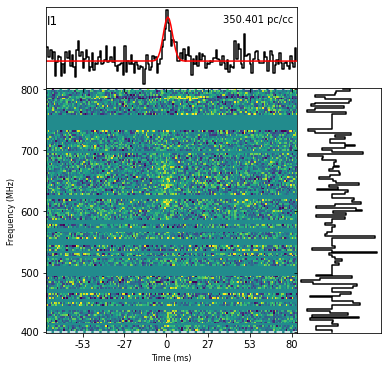

[2023-01-23 21:45:46,606] INFO Authorization Status: None
[2023-01-23 21:45:46,607] INFO Authorization Method: Tokens


144520399


[2023-01-23 21:45:46,908] INFO Authorization Token : Expired
[2023-01-23 21:45:46,910] INFO Reauthorize Method: Tokens
[2023-01-23 21:45:47,432] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2023-01-23 21:45:47,433] INFO Reauthorize Result: Passed


2169


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Degrees of freedom <= 0 for slice.


-0.24742620810866353 0.7975750202313066
38


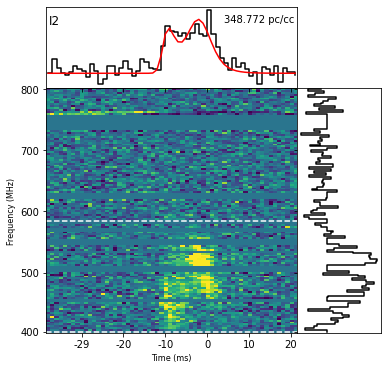

[2023-01-23 21:45:48,752] INFO Authorization Status: None
[2023-01-23 21:45:48,754] INFO Authorization Method: Tokens


154779432


[2023-01-23 21:45:49,027] INFO Authorization Token : Expired
[2023-01-23 21:45:49,028] INFO Reauthorize Method: Tokens
[2023-01-23 21:45:49,547] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2023-01-23 21:45:49,548] INFO Reauthorize Result: Passed


1169


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Degrees of freedom <= 0 for slice.


-0.2904288675636053 0.31952679795878275
34


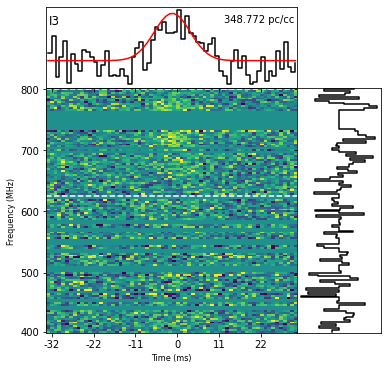

[2023-01-23 21:45:51,332] INFO Authorization Status: None
[2023-01-23 21:45:51,334] INFO Authorization Method: Tokens


157779605


[2023-01-23 21:45:51,788] INFO Authorization Token : Expired
[2023-01-23 21:45:51,790] INFO Reauthorize Method: Tokens
[2023-01-23 21:45:52,658] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2023-01-23 21:45:52,661] INFO Reauthorize Result: Passed


2169


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Degrees of freedom <= 0 for slice.


-0.3762756772339344 0.48540340084582567
83


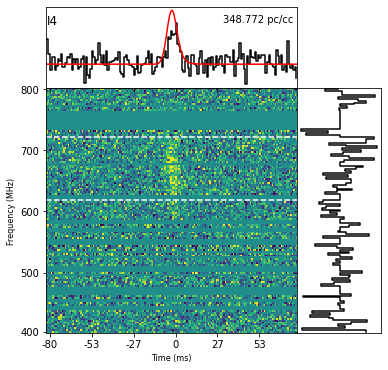

[2023-01-23 21:45:54,586] INFO Authorization Status: None
[2023-01-23 21:45:54,588] INFO Authorization Method: Tokens


162981697


[2023-01-23 21:45:55,291] INFO Authorization Token : Expired
[2023-01-23 21:45:55,292] INFO Reauthorize Method: Tokens
[2023-01-23 21:45:56,360] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2023-01-23 21:45:56,362] INFO Reauthorize Result: Passed


2169


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Degrees of freedom <= 0 for slice.


-0.6684390427544713 0.40526303350925447
80


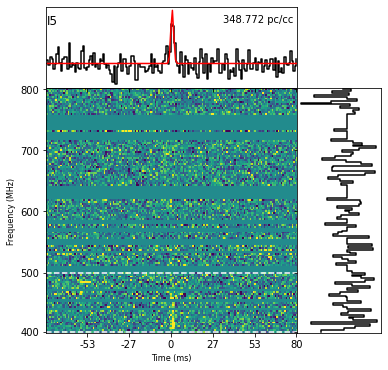

[2023-01-23 21:45:58,077] INFO Authorization Status: None
[2023-01-23 21:45:58,078] INFO Authorization Method: Tokens


163181404


[2023-01-23 21:45:58,498] INFO Authorization Token : Expired
[2023-01-23 21:45:58,499] INFO Reauthorize Method: Tokens
[2023-01-23 21:45:59,232] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2023-01-23 21:45:59,234] INFO Reauthorize Result: Passed


1169


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Degrees of freedom <= 0 for slice.


-0.5271485880948603 0.5021199239417911
78


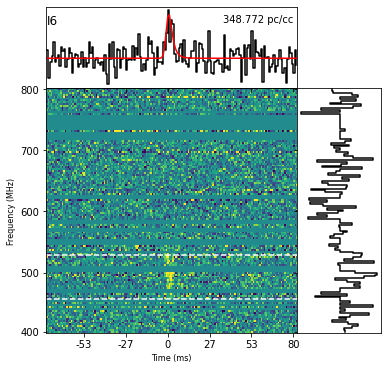

[2023-01-23 21:46:00,615] INFO Authorization Status: None
[2023-01-23 21:46:00,616] INFO Authorization Method: Tokens


165238765


[2023-01-23 21:46:00,893] INFO Authorization Token : Expired
[2023-01-23 21:46:00,894] INFO Reauthorize Method: Tokens
[2023-01-23 21:46:01,423] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2023-01-23 21:46:01,425] INFO Reauthorize Result: Passed


0169
-0.44544642365404535 0.4454605430364609


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Degrees of freedom <= 0 for slice.


81


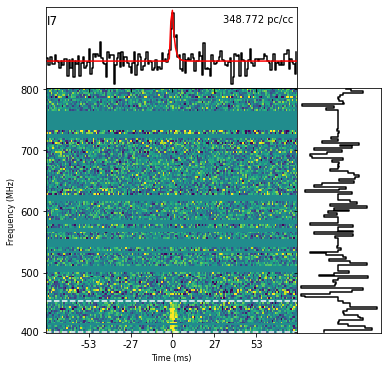

[2023-01-23 21:46:02,662] INFO Authorization Status: None
[2023-01-23 21:46:02,663] INFO Authorization Method: Tokens


175084048


[2023-01-23 21:46:27,648] INFO Authorization Token : Expired
[2023-01-23 21:46:27,649] INFO Reauthorize Method: Tokens
[2023-01-23 21:46:27,840] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2023-01-23 21:46:27,841] INFO Reauthorize Result: Passed


0169


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Degrees of freedom <= 0 for slice.


-0.4809297532774508 0.4763229436108044
80


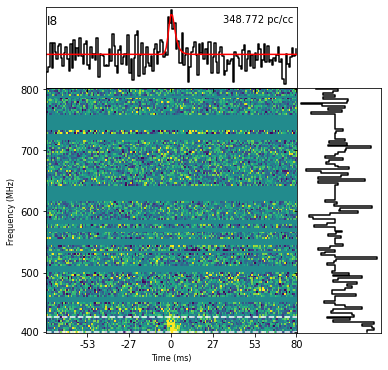

[2023-01-23 21:46:28,975] INFO Authorization Status: None
[2023-01-23 21:46:28,976] INFO Authorization Method: Tokens
[2023-01-23 21:46:29,101] INFO Authorization Token : Expired
[2023-01-23 21:46:29,102] INFO Reauthorize Method: Tokens


175930797


[2023-01-23 21:46:29,292] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2023-01-23 21:46:29,293] INFO Reauthorize Result: Passed


2169


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Degrees of freedom <= 0 for slice.


-0.5636655278503895 0.5847776091347139
81


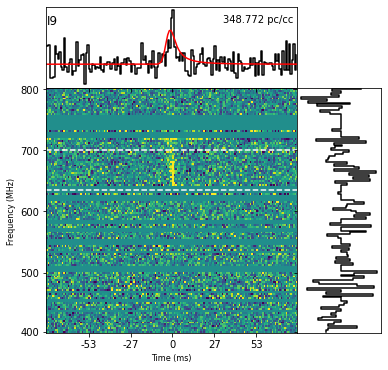

[2023-01-23 21:46:30,835] INFO Authorization Status: None
[2023-01-23 21:46:30,840] INFO Authorization Method: Tokens


176156139


[2023-01-23 21:46:31,151] INFO Authorization Token : Expired
[2023-01-23 21:46:31,152] INFO Reauthorize Method: Tokens
[2023-01-23 21:46:31,688] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2023-01-23 21:46:31,689] INFO Reauthorize Result: Passed


1169


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Degrees of freedom <= 0 for slice.


-0.5785686951130629 0.4486560587372099
80


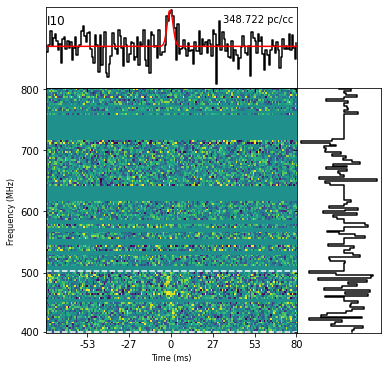

[2023-01-23 21:46:33,110] INFO Authorization Status: None
[2023-01-23 21:46:33,111] INFO Authorization Method: Tokens


183057477


[2023-01-23 21:46:33,505] INFO Authorization Token : Expired
[2023-01-23 21:46:33,506] INFO Reauthorize Method: Tokens
[2023-01-23 21:46:34,229] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2023-01-23 21:46:34,230] INFO Reauthorize Result: Passed


1169


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Degrees of freedom <= 0 for slice.


-0.3914995901286602 0.5108393758535387
35


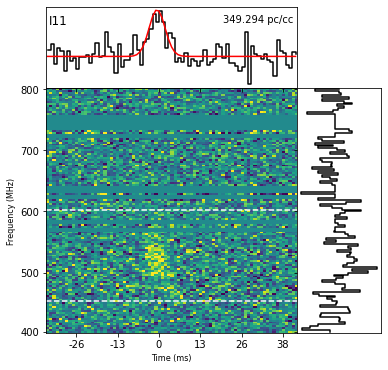

[2023-01-23 21:46:35,550] INFO Authorization Status: None
[2023-01-23 21:46:35,551] INFO Authorization Method: Tokens
[2023-01-23 21:46:35,677] INFO Authorization Token : Expired
[2023-01-23 21:46:35,678] INFO Reauthorize Method: Tokens


188760049


[2023-01-23 21:46:35,904] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2023-01-23 21:46:35,905] INFO Reauthorize Result: Passed


3169


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Degrees of freedom <= 0 for slice.


-0.5737465478479863 0.492962156732877
81


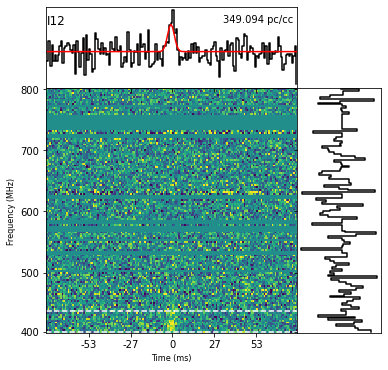

[2023-01-23 21:46:37,208] INFO Authorization Status: None
[2023-01-23 21:46:37,209] INFO Authorization Method: Tokens


188760957


[2023-01-23 21:46:37,446] INFO Authorization Token : Expired
[2023-01-23 21:46:37,447] INFO Reauthorize Method: Tokens
[2023-01-23 21:46:37,860] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2023-01-23 21:46:37,862] INFO Reauthorize Result: Passed


0169
-0.2284920498728752 0.22321268233160177


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Degrees of freedom <= 0 for slice.


19


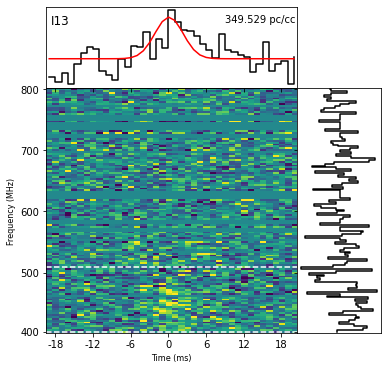

[2023-01-23 21:46:38,989] INFO Authorization Status: None
[2023-01-23 21:46:38,990] INFO Authorization Method: Tokens


198142107


[2023-01-23 21:46:39,274] INFO Authorization Token : Expired
[2023-01-23 21:46:39,275] INFO Reauthorize Method: Tokens
[2023-01-23 21:46:39,766] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2023-01-23 21:46:39,767] INFO Reauthorize Result: Passed


1169


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Degrees of freedom <= 0 for slice.


-0.9159014398852984 0.8880087234079839
120


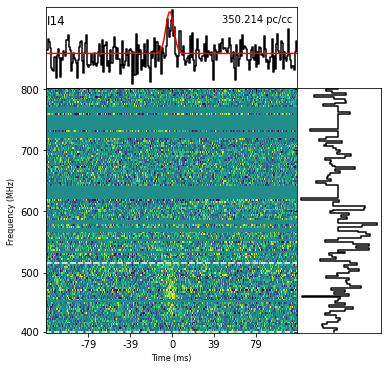

[2023-01-23 21:46:42,432] INFO Authorization Status: None
[2023-01-23 21:46:42,432] INFO Authorization Method: Tokens


201096712


[2023-01-23 21:46:42,864] INFO Authorization Token : Expired
[2023-01-23 21:46:42,864] INFO Reauthorize Method: Tokens
[2023-01-23 21:46:43,632] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2023-01-23 21:46:43,633] INFO Reauthorize Result: Passed


1169


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Degrees of freedom <= 0 for slice.


-0.4882704261690377 0.3705084938555956
81


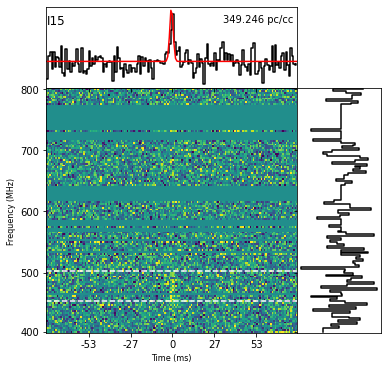

In [6]:
#### Redo 165238765 #####
for i in range(len(events)):
    event_id = events[i]
    wfall, model_wfall, model_ts, model_spec, spec = get_event_data(event_id, ro[i])
    wfall, model_wfall, spec = rfi_clean(wfall, model_wfall, spec)
    #plt.plot(model_spec)
    dm = dms[i]
    save_fname = 'wfall_intensity/I{}_wfall_int_fin.pdf'.format(int(i+1))
    t_res = 0.983
    f_res = 400/wfall.shape[0]
    #low, high, peak = get_spec_param(model_spec, 400, 800, wfall.shape[0])
    plot_event(wfall, model_ts, f_res, t_res, dm, i, lo[i], hi[i], save_fname)


(1024, 81)
(81,)
(1024,)
[   0  256  512  768 1024]
[400 500 600 700 800]
40


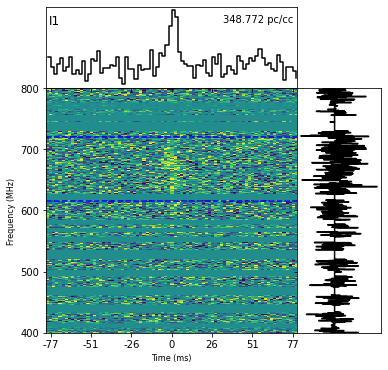

(1024, 81)
(81,)
(1024,)
[   0  256  512  768 1024]
[400 500 600 700 800]
41


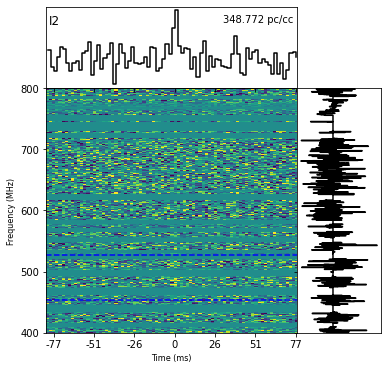

(1024, 81)
(81,)
(1024,)
[   0  256  512  768 1024]
[400 500 600 700 800]
40


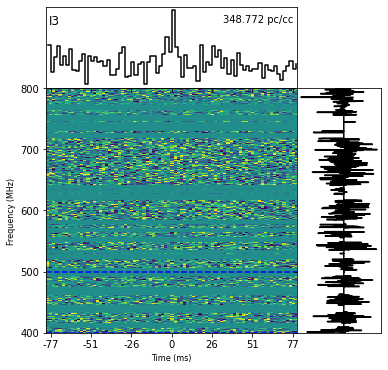

(1024, 81)
(81,)
(1024,)
[   0  256  512  768 1024]
[400 500 600 700 800]
40


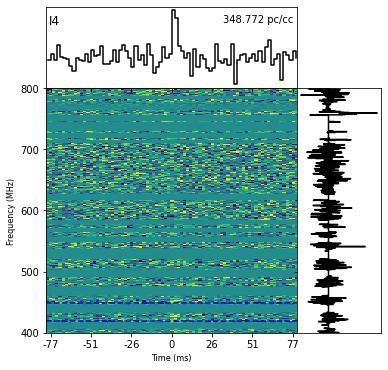

(1024, 81)
(81,)
(1024,)
[   0  256  512  768 1024]
[400 500 600 700 800]
40


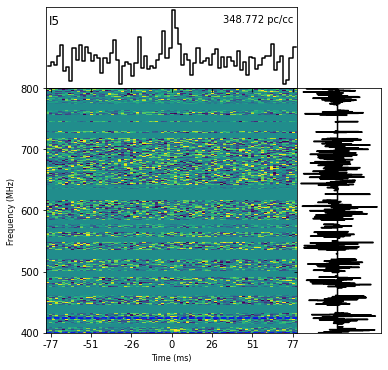

(1024, 81)
(81,)
(1024,)
[   0  256  512  768 1024]
[400 500 600 700 800]
40


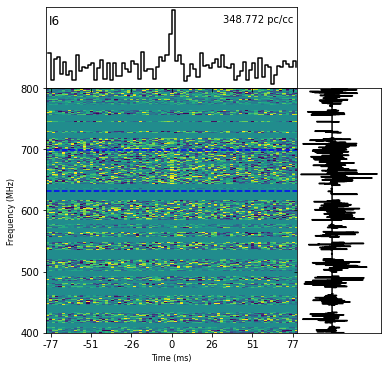

In [3]:
R3_e_fon = [157779605, 162981697, 163181404, 165238765, 175084048, 175930797]
R3_e_fon = np.array(R3_e_fon)

for i in range(len(R3_e_fon)):    
    
    save_path = '/data/user-data/ksand/baseband-analysis/playground/wfall_intensity/'
    
    event_id = R3_e_fon[i]
    file_npz = '/data/user-data/efonseca/runs/R3/solutions/with_scattering/test_data_CHIMEFRB_{}.npz'.format(event_id)
    data_npz = np.load(file_npz, allow_pickle= True)
    
    file  = '/data/user-data/efonseca/runs/R3/solutions/with_scattering/results_fitburst_{}.json'.format(event_id)
    data = pd.read_json(file)
    
    dm = data["model_parameters"]["dm"][0]
    cf = data["fit_statistics"]["bestfit_parameters"]["freq_mean"][0]
    bw = data["fit_statistics"]["bestfit_parameters"]["freq_width"][0] * 2.575 ### Multiplying to get 3 sigma(99%)
    
    ### The lower and upper frequency ####
    
    low = cf - bw/2
    high = cf + bw/2
    
    if low < 400:
        low = 400
    if high > 800:
        high = 800
    
    
    
    wfall = data_npz["data_full"]
    
    f_scrunch = 16
    t_scrunch = 2
    
    f_res = (400/16384)*f_scrunch 
    t_res = 0.983 * t_scrunch #ms
    
    save_fname = save_path + 'wfall_'+ str(event_id)+'.jpeg'
    
    wfall = scrunch_npy(wfall, f_scrunch, t_scrunch) 
    
    plot_event(wfall, f_res, t_res, dm, i, low, high, save_fname)
    

    

In [ ]:
events_to_rerun_fitburst =  188760049, 201096712